# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [3]:
def get_cost(x,u):
    
    cost = (x[0] - np.pi)**2 + 0.01*(x[1])**2 + 0.0001*u**2
    
    return cost

In [4]:
def get_policy_and_value_function(q_table):
    
    u = np.array([-4,0,4])
    value_function = np.zeros([50,50])
    policy = np.zeros([50,50])
    
    
    for i in range(50):
        for j in range(50):
            
            index = np.argmin(q_table[i,j])
            value_function[i,j] = q_table[i,j,index]
            policy[i,j] = u[index]
            
    return value_function, policy

In [5]:
def q_learning(q_table):
    
    γ = 0.3
    ε = 0.1
    α = 0.99
    u = np.array([-4,0,4])
    
    c = []
    
#     q_table_prev = q_table
    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    for i in range(10000):
        
        x = np.array([0, 0])
        cost = 0
        theta_index = np.argmin(np.abs(thetas - x[0]))
        omega_index = np.argmin(np.abs(omegas - x[1]))
        
        for j in range(100):
            
            
            if np.random.rand() < ε:
                
                u_index = np.random.randint(0,3)
#                 u_index = np.argmin(q_table[theta_index,omega_index,:])
                
            else:
                
                u_index = np.argmin(q_table[theta_index,omega_index])
#                 u_index = np.random.randint(0,3)
                
            x_next = pendulum.get_next_state(x,u[u_index])
            
            new_theta_index = np.argmin(np.abs(thetas - x_next[0]))
            new_omega_index = np.argmin(np.abs(omegas - x_next[1]))
            
            
            δt= get_cost(x,u[u_index]) + α*np.min(q_table[new_theta_index,new_omega_index,:]) - q_table[theta_index,omega_index,u_index]
            
            q_table[theta_index,omega_index,u_index] = q_table[theta_index,omega_index,u_index] + γ*δt
            
            theta_index = new_theta_index
            omega_index = new_omega_index
            x = x_next        
#             q_table_prev = q_table
            cost +=get_cost(x,u[u_index])
    
        c.append(cost)
#         print(c)
        
                
    return q_table, c

In [6]:
q_table = np.zeros([50,50,3])
q_table, c = q_learning(q_table)

<IPython.core.display.Javascript object>


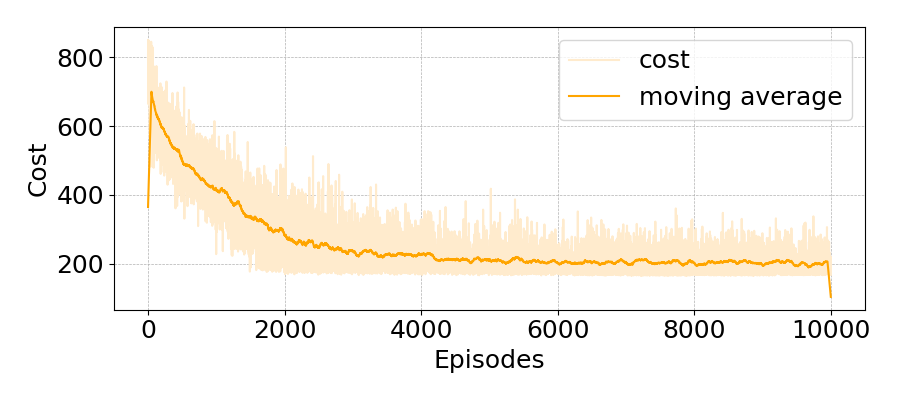

In [7]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,4])
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

c_av = movingaverage(c, 100)

plt.plot(c,color = 'blanchedalmond', label = 'cost')
plt.plot(c_av,color = 'orange', label = 'moving average')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [8]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    u = np.array([-4,0,4])
    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    theta_index = np.argmin(np.abs(thetas - x[0]))
    omega_index = np.argmin(np.abs(omegas - x[1]))
    
    u_index = np.argmin(q_table[theta_index,omega_index,:])
    
    return u[u_index]


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

<IPython.core.display.Javascript object>


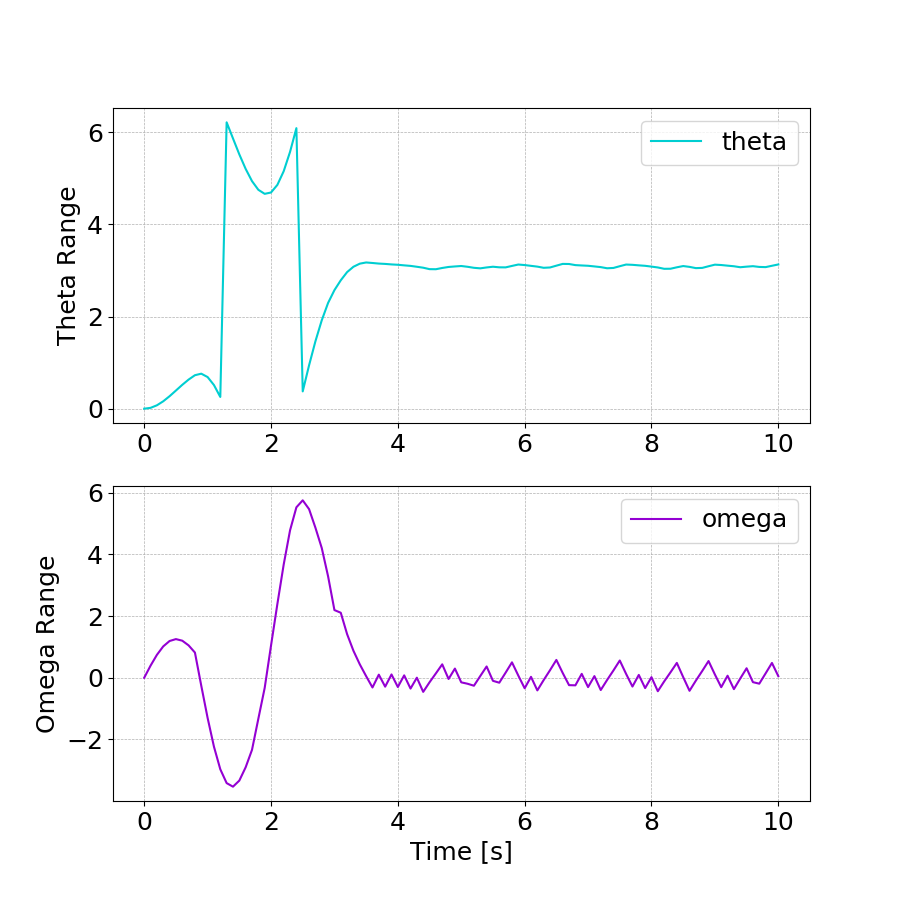

Text(0, 0.5, 'Omega Range')

In [9]:
# we can plot the results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,9])

plt.subplot(2,1,1)
plt.plot(t, x[0,:], color = 'darkturquoise')
plt.legend(['theta'])
plt.grid(True, linestyle='--', linewidth = 0.5)
# plt.xlabel('Time (sec)')
plt.ylabel('Theta Range')

plt.subplot(2,1,2)
plt.plot(t, x[1,:], color = 'darkviolet')
plt.legend(['omega'])
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Omega Range')

<IPython.core.display.Javascript object>


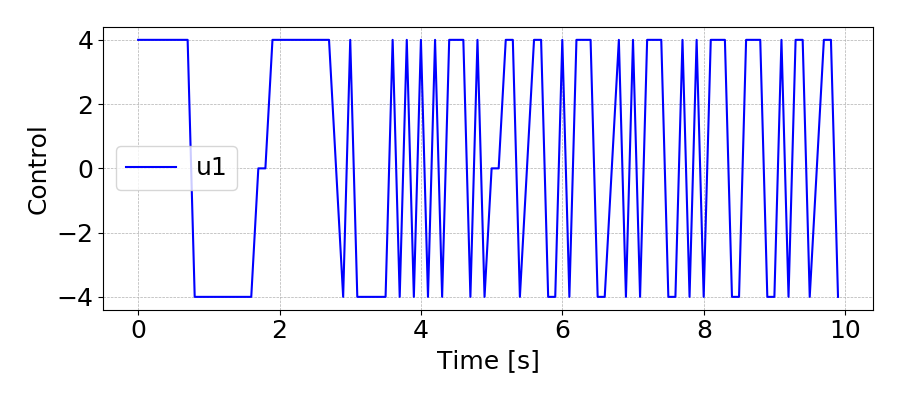

In [48]:
# we can also plot the control
plt.figure(figsize = [9,4])
plt.plot(t[:-1], u.T, color = 'blue')
plt.legend(['u1'])
plt.xlabel('Time [s]')
plt.ylabel('Control')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [11]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACKbW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAATKGWI
hAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIGZJnp
cUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+WqZvqh
qAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G2fPt
zPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwovx46y
wGgxxfs9fMlS020C3xva70m3s1SHWEouXnQ9W4XloF47fXCs4k4fwINVZqbSm6sqgmjTMl46JRdJ
v3yRvepGomS8jKKelb08tceKwF8bNEgAwpfyAPe51d/0300RYn12YGK44M+XewjSpd9WJNWrJWDp
V7SIyJSHBAd0kt/BSJoK+vRQf9qWVihroOFzbNb979ddoxam7YOvs6wZXpH+qNaYgo6yuj8eukNQ
wqm5Hl1eyy0Mtbbg1WUM3/PmpQxDeZMA3Jqjpf43KsglB+HSOlCZTkW1ylgxdCoBs9vvoGw1DuRe
wYNX+BT8hpKEbQlGH/cnywE1OQzWCRET/M+JadsP0nh47rxhXQ5sj00rOR0G7dWF8RRkvqJYSFLE
fMwJTcV82dya9KgflcV45ACZEL/okLWNCe5SP0SB96rjpJIc+G1awMVl15gt4PHB11HbNDQQiNJv
1P8cwCwIXZpFZafFWMcAgB6P6LU+TI5tirBJSEgIjuWh1KO/sKC+3bL++cOdhMrI2N+MWcDzDBAQ
FAnk++HfcKRAHclzN+x4dvoK8grehoZKkDbx0aopPbnuhtgw2OYANePt0DdQAAADAQegBrjiBtur
f3LhPsqJbPmu/ht22a4P+MAU4XC07n9BJ9VvTzGNfWAThP0my/RWgarXlyAdYp1j0Z9aAKXxwW1e
UkotJumCzHJ4yPKL0R5pABVH/OK0N0gAdtgEje79ymE/8qWEgKwtlHfByeDVJ7DBUGYmG/eaIjth
OgaMEpKNqrHqF1TSp0QNT2//7vhwAmzl01XKNSdX9eWN08Cy0c++Gam7atyi65+b+d/hgmNhl7+t
+0t6LdpTTO2gnqiteBi1bDWOiQMG+Ph05ZuXJnr7hGpIy2A3J50HQFFIXFRDEteAU+tNQkGSNVNA
cM87uV1ZHokLhX2b3ArwXH3U8InZxh1uBARTL9J+cetgzeMSUHT9GSQI34m+TCywScBjN1i3QqM6
dZ5Tf3aDWVO2PmSGRcyHq7SJm7fTTZn3j8Xr3a1asxCxkFN/ABKFo5Hi7TpPe8xccjY1xTVEdgIp
hqwhMV5cn5o3QAzFD//24MWmk/ioUe7QGhu0lgK192IbgNGk6B9GuSnvPimhb3YX/UEPC+vsUqJR
dLGfmQZvZ9f4HRVtprpVREjdnScnUOYO1y8DfHTP+p6mACwVOc5/vr8bCWKjs7Nm4+I0XMf21Y1o
i0ZNZoKwP2tGtlA0WxNBxa++RJvXBzxkX41WtJeTZgE6SRr4Z+wlR23K4AACiAAAAwAK1MiQrbUK
9mYLXxtxjNdlYAppoA0ge1yQRkMU/GBEcP5Ccpv5wqxQIjOcfBxdwr7WWCPmAOVTii5+Hf8V7dQB
UrovD+Oz2REXOkaZzfgK9KgakznEvWBWDrs863cnuSG2bSbPmgtVjS2xzvzZQifyJf8avBWL1EQd
fDqK34e8NGR+oy7CkXsnaMFa92jVd/fpB1yfmTqw3b0flBxPOCVDZ4Evk5ypRc9erAfLqTxIFPKO
wzP7hUREFL4bNt3dGvfylNOlElYCJzsTu5fgJTof7gXANOL/yKhKHEescMygKJb9oQkf/WvNyvnd
0hhK12WTVDrcqF64VIl9wFUYhriOuHgm7m7G82mER4DKkfwu0p7q/Wrms6w3SY4IWh9lm883+k1t
ZcpO9iQH6ooRm4zihvA056dOPg7XgnDhBzDrtZl4mO4P/YtekJ/JSSdYKDHYuNJbnbQSRcLY4h8Y
e3Be5+6xVNx+w0qDqUhJey80OiMRdwe7ImVwQpHvyPuVaOevCHzHqGS/NfORVpfumY1+niIk38pw
ELWI8Ioey5ECSBOrhGGIDWgf1YxyrmlT0YtX+xc+BpmqjQMKrAH3Vf6KJaDD3riTfjyIvjbovlHN
kXMxCBVCtIWd1El7ZqM3f2u2aQNEvEj4rgbXgVzz3RHATv2dPeK1uUPx0Fv1UoSG3QwZRXpEmPpz
hESet+dn7kKwa5XCG2Y9FNJUrPxt8NwhuvAak6dOHVIkJFXemWWBjhsqsR6CkX1R6WvMLoL8tTiJ
M5ou1CIjjFgRJK7k6JPTvTYp0p90uyiNcdlxeCgGZF7clEuFIS/mnwPPLklpFcVIBrye9KKaugkW
e1HnkE2+/7tn5EiiSvZHnlE4Q3yZDqu/WsDojINBDb4kle2L4W+OVVzfrXdiytcVwBtsb+HK6QKY
TUXp2jdfdg2KGpkbXLYaZaZ8j2aAknTFGRaVX1q6IufEjUmteYYX1i5eu2Af5wqUhMPuS/hQXtRQ
Qt8EpZoYcJUuBKjgO+GjoHiaBrKL2qKO1SWR190BKzlUNOUpvIpjR6SFil+IF9gbEXqdgSwyWDVr
VoPRoU7p+JqQuFp4K2eij67nJIyOm5W43/t/aNBJ/0p/b7Gg+yYBtL4REwmvvoQBSG86DDgkm6vq
5/V4V+JcWoeMXM9FzBsDUrTfyb7jp/qCKjqh/KFmAbM0ijCjdTmcmceVOHUfVnrEZfDcY0kOanbz
Q9kt/Cy/qrVOV/lys3Jd3MChk/rLPFvUiFMgbkoY3sn67MnNTzlBCwy21risUycRObRWO+CLHB3J
tQWq4+GRGSYAVzNHZNK7B

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

<IPython.core.display.Javascript object>


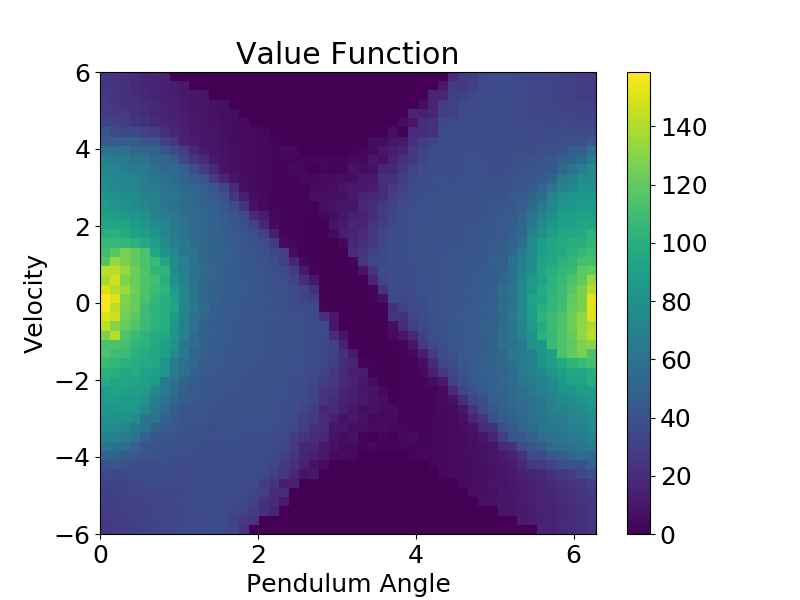

<IPython.core.display.Javascript object>


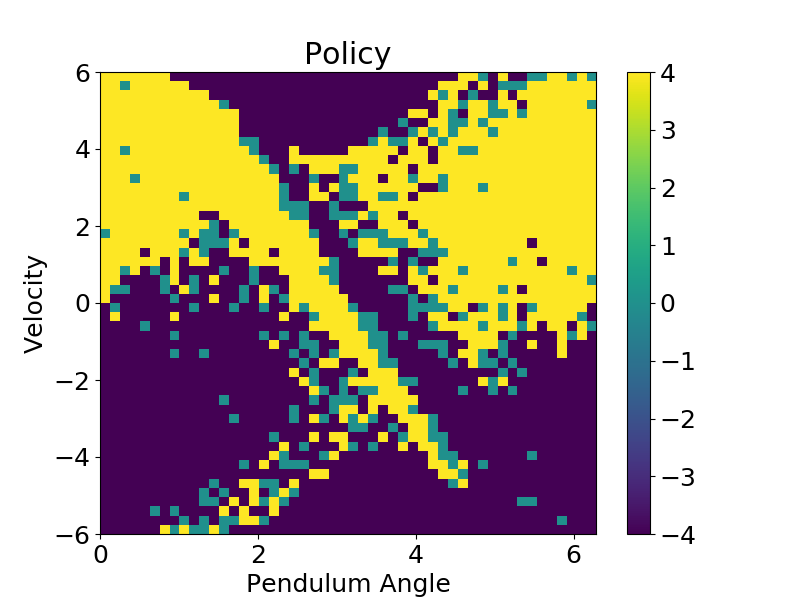

In [12]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function(q_table)

# we plot the value function
plt.figure(figsize=[8,6])
plt.imshow(value_function.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')
plt.colorbar()

# we plot the policy
plt.figure(figsize=[8,6])
plt.imshow(policy.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')
plt.colorbar()

# Generating for u = [-5, 0,5]

In [13]:
def get_policy_and_value_function2(q_table):
    
    u = np.array([-5,0,5])
    value_function = np.zeros([50,50])
    policy = np.zeros([50,50])
    
    
    for i in range(50):
        for j in range(50):
            
            index = np.argmin(q_table[i,j])
            value_function[i,j] = q_table[i,j,index]
            policy[i,j] = u[index]
            
    return value_function, policy

In [14]:
def q_learning2(q_table):
    
    γ = 0.3
    ε = 0.1
    α = 0.99
    u = np.array([-5,0,5])
    
    c = []
    

    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    for i in range(10000):
        
        x = np.array([0, 0])
        cost = 0
        theta_index = np.argmin(np.abs(thetas - x[0]))
        omega_index = np.argmin(np.abs(omegas - x[1]))
        
        for j in range(100):
            
            
            if np.random.rand() < ε:
                
                u_index = np.random.randint(0,3)
                
            else:
                
                u_index = np.argmin(q_table[theta_index,omega_index])
                
            x_next = pendulum.get_next_state(x,u[u_index])
            
            new_theta_index = np.argmin(np.abs(thetas - x_next[0]))
            new_omega_index = np.argmin(np.abs(omegas - x_next[1]))
            
            
            δt= get_cost(x,u[u_index]) + α*np.min(q_table[new_theta_index,new_omega_index,:]) - q_table[theta_index,omega_index,u_index]
            
            q_table[theta_index,omega_index,u_index] = q_table[theta_index,omega_index,u_index] + γ*δt
            
            theta_index = new_theta_index
            omega_index = new_omega_index
            x = x_next        
            cost +=get_cost(x,u[u_index])
    
        c.append(cost)
        
                
    return q_table, c

In [15]:
q_table = np.zeros([50,50,3])
q_table2, c2 = q_learning2(q_table)

<IPython.core.display.Javascript object>


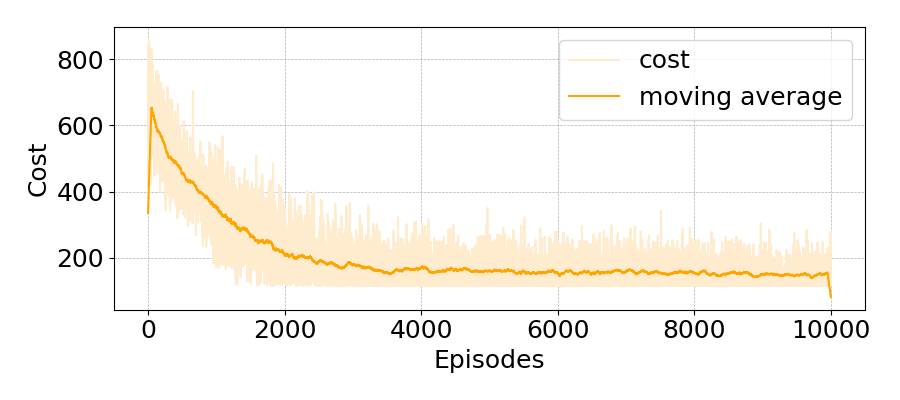

In [16]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,4])
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

c2_av = movingaverage(c2, 100)

plt.plot(c2,color = 'blanchedalmond', label = 'cost')
plt.plot(c2_av,color = 'orange', label = 'moving average')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [52]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller2(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    u = np.array([-5,0,5])
    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    theta_index = np.argmin(np.abs(thetas - x[0]))
    omega_index = np.argmin(np.abs(omegas - x[1]))
    
    u_index = np.argmin(q_table2[theta_index,omega_index,:])
    
    return u[u_index]


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x2, u2 = pendulum.simulate(x0, dummy_controller2, T)

<IPython.core.display.Javascript object>


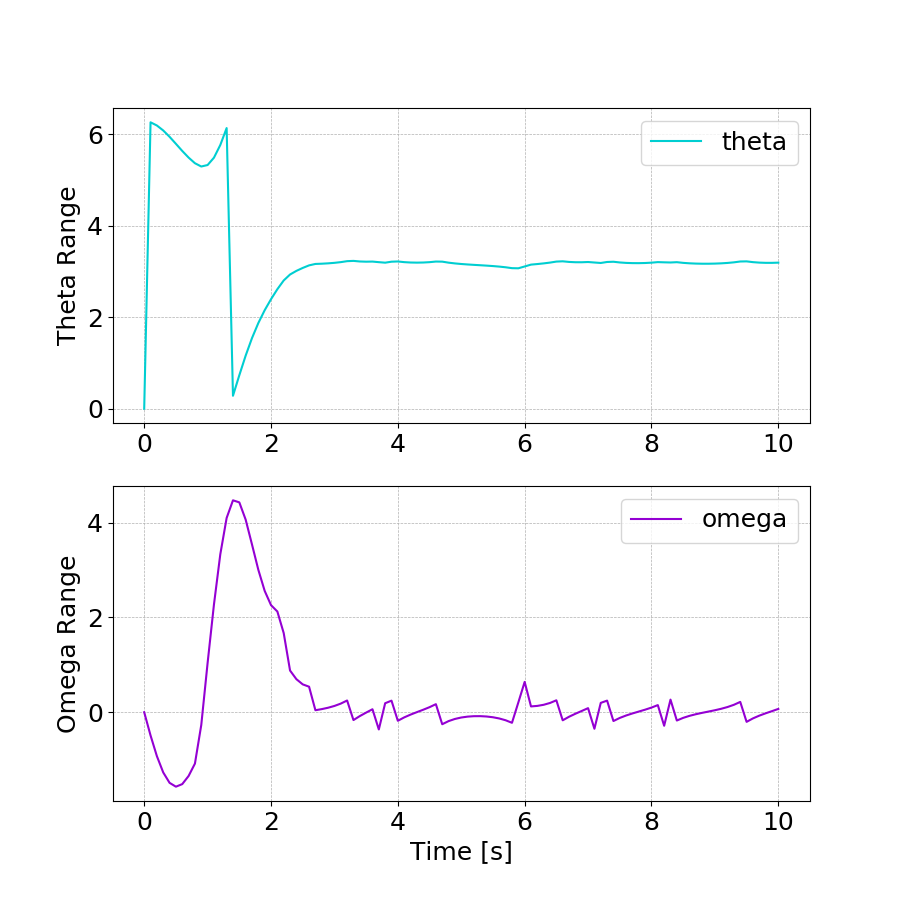

Text(0, 0.5, 'Omega Range')

In [53]:
# we can plot the results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,9])

plt.subplot(2,1,1)
plt.plot(t, x2[0,:], color = 'darkturquoise')
plt.legend(['theta'])
plt.grid(True, linestyle='--', linewidth = 0.5)
# plt.xlabel('Time (sec)')
plt.ylabel('Theta Range')

plt.subplot(2,1,2)
plt.plot(t, x2[1,:], color = 'darkviolet')
plt.legend(['omega'])
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Omega Range')

<IPython.core.display.Javascript object>


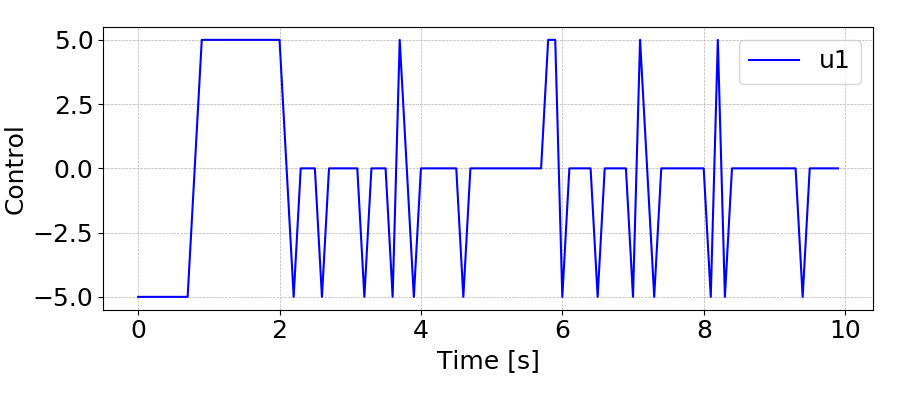

In [54]:
# we can also plot the control
plt.figure(figsize = [9,4])
plt.plot(t[:-1], u2.T, color = 'blue')
plt.legend(['u1'])
plt.xlabel('Time [s]')
plt.ylabel('Control')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [57]:
# now we can also create an animation
pendulum.animate_robot(x2)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB4tm1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAATFGWI
hAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIGZJnp
cUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+WqZvqh
qAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G2fPt
zPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwovx46y
wGgxxfs9fMlS020C3xva70m3s1SHWEouXnQ9W4XloF47fXCs4k4fwINVZqbSm6sqgmjTMl46JRdJ
v3yRvepGomS8jKKelb08tceKwF8bNEgAwpfyAPe51d/0300RYn12YGK44M+XewjSpd9WJNWrJWDp
V7SIyJSHBAd0kt/BSJoK+vRQf9qWVihroOFzbNb979ddoxam7YOvs6wZXpH+qNaYgo6yuj8eukNQ
wqm5Hl1eyy0Mtbbg1WUM3/PmpQxDeZMA3Jqjpf43KsglB+HSOlCZTkW1ylgxdCoBs9vvoGw1DuRe
wYNX+BT8hpKEbQlGH/cnywE1OQzWCRET/M+JadsP0nh47rxhXQ5sj00rOR0G7dWF8RRkvqJYSFLE
fMwJTcV82dya9KgflcV45ACZEL/okLWNCe5SP0SB96rjpJIc+G1awMVl15gt4PHB11HbNDQQiNJv
1P8cwCwIXZpFZafFWMcAgB6P6LU+TI5tirBJSEgIjuWh1KO/sKC+3bL++cOdhMrI2N+MWcDzDBAQ
FAnk++HfcKRAHclzN+x4cxsZeWRFGL5vHOVt+8FgVyyNFHx4QIVPS5bY5AAAAwBNkAKAgyNmfitS
4T7KiWz5rv4bdtmuD/i/5QFwtO5/QSfVb88xjX1gE4T9Jsv0VnRq15cgHWKdY9GiWgCl8cFtXlBq
LUNLFNt/VfGRwgIwDSAZ4/Dirdf6Mff5Fg3OOwVezUly1wObPZpkhSlw1SewwVBmJxz1eGhGYToG
jBKSjarZfBdU0qdEDU9v/+74cAJs5cy2uYknV/Xlj1PAstHPvhmpu6vUvOufm/nZ4YJjYZfTrftL
ei3aU01RoJ6orXgYtWxFjokDBvj4dOWbl4Z6+432ciDAbk86DoIikLiohiWvAKfWmoSDJGqmmWcP
EAEtgDFSFwr7N7gV4Lj7qeETs4w63BmtJjxy/OPWwZvGJODp+jJIEb8WkKBp2xX8fkxw9Ffq+laH
fXsKWmSPKbgkhkXMh6u0iZu3002Z94/F692tWrMQsZBTfwAShaOR4uthPXvMXHI2NcU1RHYCKYas
ITFeXJ+aN0AMxQ//9uDFppQmqFHu0IXly1T3hmwSF/0qAxQHJl3j3nxTRB7sMB6CHhfaVnS7yaFs
oGi2IN/13+iFeMG+Le8pI3Z+LE0snh6OC6BFlLHPWeJOCWqeMZvz8i4v6zVL3YpGJC7gnXef+/K2
9OCUR0jEeZXrWFZAn64vd1tv4T13RqtYYfu8R3v1GvgvF8l0JOegAADjAAADAAX3SkM1hnz7FfaH
co9IM7KwBQ4MwhxvnJBGQxT8YERwECcv4wiXy1Orvn4knS7hX2ssEfMAce1W/zsO/oLSasht1hXt
8dnsiIl9GrSkPAV6VBawAO5QSdYOuzzwVxBmwoBvvLMDogRuNmbN+bKET+RCpE8fhqe84EPh1Fb+
yLYOQ/MOThSL9iFYQ2p5n6d/UEWPileiigpqEkNSQnnCohs8CXxxb6L3ujbRTJLOMjNSKJFp2HCJ
o9NptslluPjVn5SmnSiSjUak9JPJZuxpP9IML0Jvdrii7ADiPWOGZQEwb/S6zT3eSAM6cndIYojq
ysWi+w2w/ER1QBHjDIbUa+zBD65waPr9B1oIqXcf4tEF42hcWrQfFVlSVo1FOHujlHHCXhvH2ijG
sDL11obY3OXf9G7g+SnRlu2r13Rm7ynRhaE4nrtv8GV3M12LdUBaWpM9WcP39xbx/HLpTIGI1KwN
vfFlKYvcLzJ9ATYnuZoG3oITV1/GHGusOffC9cA95Owy4CJEzr954iJNp5R+V1AVUswB7Q8jRQ5e
K5CADVGDPJB2GtgUsTyGbLIPRqVsLtq6NEYKJjJ93jSR64k348iL424+JIQMVzMQgerWkLO6iS9s
1GdA5zzOIGiXiR/Fj/Tquvp9u5SqX/PI7DIHKH46C4WGfookzxM/s4GgmJ1zQfwogI0BNY4mj8Fi
i4MiVTjxRM0wYo07rkDE+igYsvhYaJLHkttJsb+c4W+GLgm9WSUWwevlZu8GHn/lwwbJL6eVpdCJ
f/Q8eRKgFaGAMoU3v4gE6FwpCJbCWJKKt52+CA6vJspkXVIEH/WF7Nyby+KJNHNngloNHx9J4o7E
W+js0Uubr/LLlhddv1Fq71gdEZBoIdu/Amc11LfHKq5v1sXgL2M7AzWyVWDldIFMGG0/zOvQShcS
5gT/6qmubHsIO3h1lroq3rlC27ZBPmJGpNa9Lpf+zZQATyXwa3aoPu69QVQxe1FBC3wTWex5AlS4
EqOA74T246TFpnzgai9M2OOp8sPpsSsuzFKItenfu+aV0g3okqYUP7e48S76+mgCF4S4nguT6Bw9
fT+NwMy393agfuAlDvyGKZ+9o0En/Sn9AWPp9B6xdzzvH73Y+hADYSrgQcEk3V9XQJZyktUNeP/E
GkdgqKIVSp5PyA/m3QWLEuLJMoWYBszObVLBqczkzjypxKYgzEw4Cl2cYtayPc18d5puPML1dciR
xivMG0XudyxfbN+M9zzWAKQqMNfGlhWt3JSSmeLjFlFG6rjR1XQ+0tCOXlzpuDuTagtVx8RHdrZh
lHveAUp5nWFDZZzgmvgM7

<IPython.core.display.Javascript object>


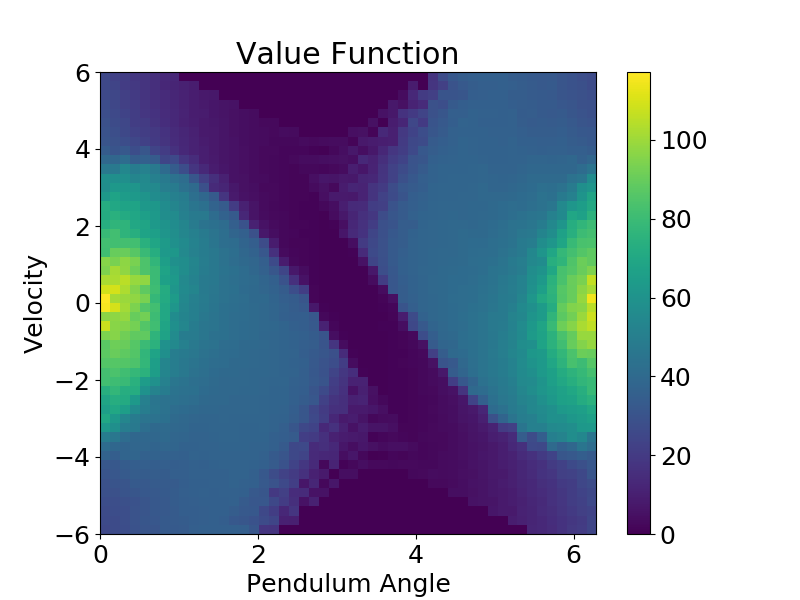

<IPython.core.display.Javascript object>


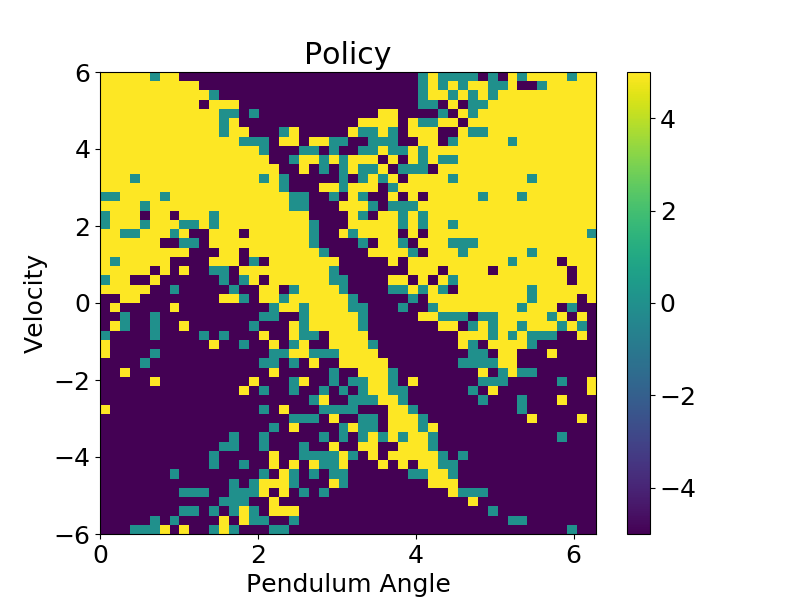

In [56]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function2(q_table2)

# we plot the value function
plt.figure(figsize=[8,6])
plt.imshow(value_function.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')
plt.colorbar()

# we plot the policy
plt.figure(figsize=[8,6])
plt.imshow(policy.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')
plt.colorbar()

# increasing the value of epsilon

In [22]:
def q_learning3(q_table):
    
    γ = 0.3
    ε = 0.8
    α = 0.99
    u = np.array([-4,0,4])
    
    c = []
    

    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    for i in range(10000):
        
        x = np.array([0, 0])
        cost = 0
        theta_index = np.argmin(np.abs(thetas - x[0]))
        omega_index = np.argmin(np.abs(omegas - x[1]))
        
        for j in range(100):
            
            
            if np.random.rand() < ε:
                
                u_index = np.random.randint(0,3)
                
            else:
                
                u_index = np.argmin(q_table[theta_index,omega_index])
                
            x_next = pendulum.get_next_state(x,u[u_index])
            
            new_theta_index = np.argmin(np.abs(thetas - x_next[0]))
            new_omega_index = np.argmin(np.abs(omegas - x_next[1]))
            
            
            δt= get_cost(x,u[u_index]) + α*np.min(q_table[new_theta_index,new_omega_index,:]) - q_table[theta_index,omega_index,u_index]
            
            q_table[theta_index,omega_index,u_index] = q_table[theta_index,omega_index,u_index] + γ*δt
            
            theta_index = new_theta_index
            omega_index = new_omega_index
            x = x_next        
            cost +=get_cost(x,u[u_index])
    
        c.append(cost)
        
                
    return q_table, c

In [23]:
q_table = np.zeros([50,50,3])
q_table3, c3 = q_learning3(q_table)

<IPython.core.display.Javascript object>


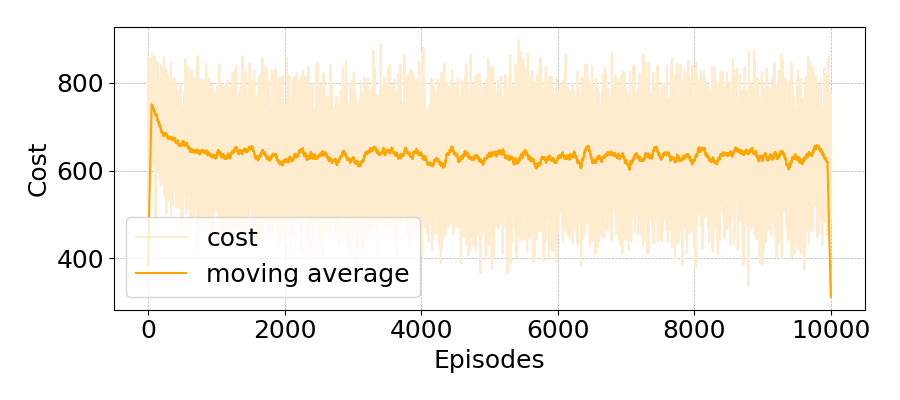

In [24]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,4])
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

c3_av = movingaverage(c3, 100)

plt.plot(c3,color = 'blanchedalmond', label = 'cost')
plt.plot(c3_av,color = 'orange', label = 'moving average')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [25]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller3(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    u = np.array([-4,0,4])
    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    theta_index = np.argmin(np.abs(thetas - x[0]))
    omega_index = np.argmin(np.abs(omegas - x[1]))
    
    u_index = np.argmin(q_table3[theta_index,omega_index,:])
    
    return u[u_index]


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x3, u3 = pendulum.simulate(x0, dummy_controller3, T)

<IPython.core.display.Javascript object>


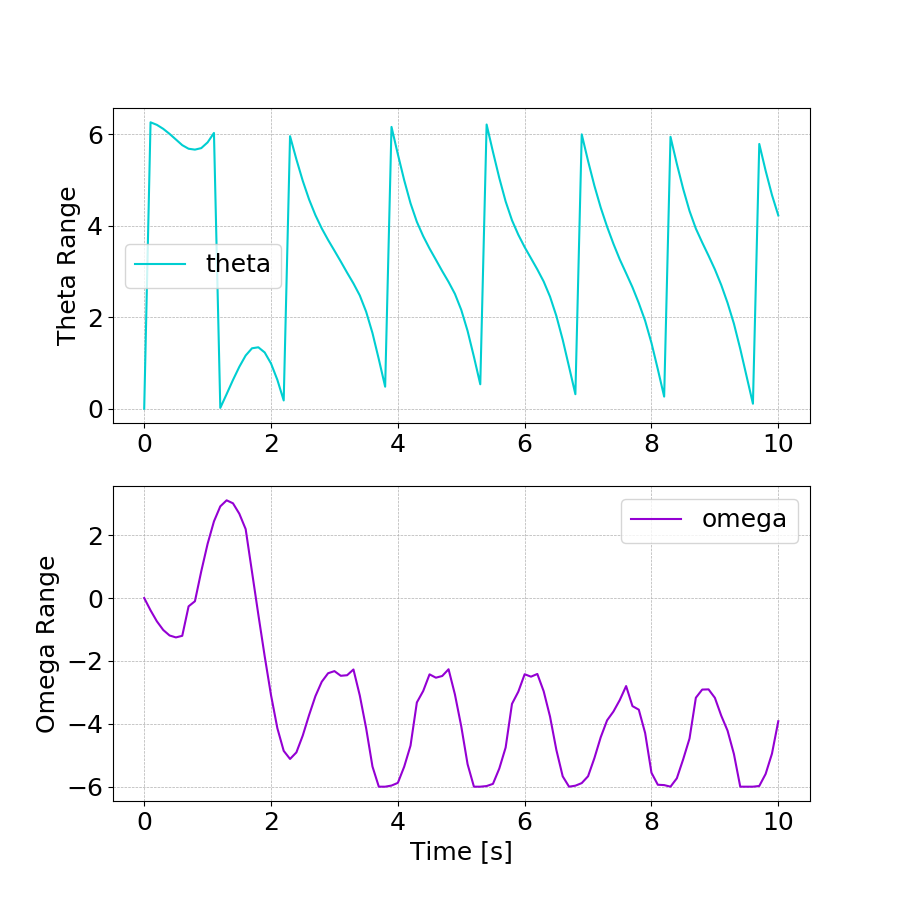

Text(0, 0.5, 'Omega Range')

In [26]:
# we can plot the results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,9])

plt.subplot(2,1,1)
plt.plot(t, x3[0,:], color = 'darkturquoise')
plt.legend(['theta'])
plt.grid(True, linestyle='--', linewidth = 0.5)
# plt.xlabel('Time (sec)')
plt.ylabel('Theta Range')

plt.subplot(2,1,2)
plt.plot(t, x3[1,:], color = 'darkviolet')
plt.legend(['omega'])
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Omega Range')

<IPython.core.display.Javascript object>


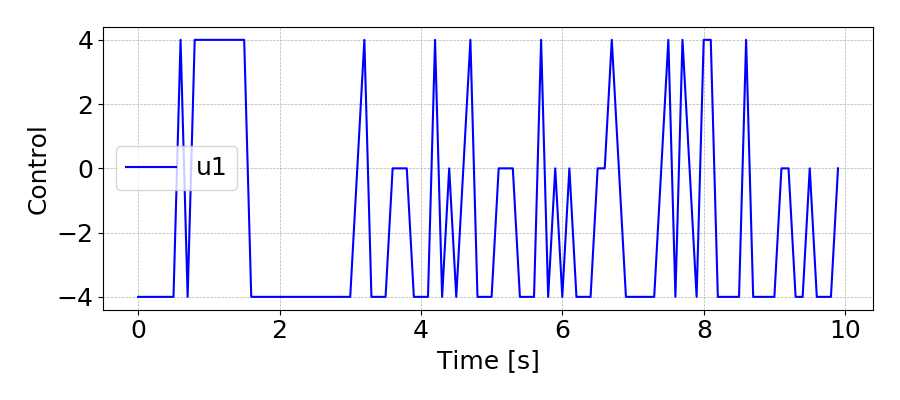

In [49]:
# we can also plot the control
plt.figure(figsize = [9,4])
plt.plot(t[:-1], u3.T, color = 'blue')
plt.legend(['u1'])
plt.xlabel('Time [s]')
plt.ylabel('Control')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [28]:
# now we can also create an animation
pendulum.animate_robot(x3)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADxl21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAATJ2WI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320jncAqssSvtJt7NUh1hKLl50PVuKrrqytTymrOJOH8CDVWar0purKodI0zJeOimcq
bsTy++vIhJq7TluOY3ReWuPFYC+NymwAYUv5AHvr8KP6b6aIsUDpJiwpfeW3PfHhUvErEms1lqhs
q9469EpDggO6SXEgpE0FfthO1yVHR15Mu2CoIj+kG/XXaMWpu2Dr7OsGV6Z/qjWmIKOveP49dYdp
/C1NTyV7LLQy11L5NNSfsLWc4sQ3mTANyao6X+NykAy7mjb2tCZVkWZylgxdCoBs9vyRDhqF97tn
nhaSOn5DSXkvCUcUdul+EnqchmsEiIn+Z8Zfl5vjWnjuoAD1J4qVBKzkdBu3VhfEUZL6iWE5SxH1
eCnWfKMPTrbGAzainxDUyrD54ulVzC5T8pH6JA+9Vx0klmfDatYGKy68wW8Tjg66jtzlsm0fGU4t
ZJ8Bzyw3NFZafFWMcAmB4P6LU+TI5tishJSEgIjuWh85+/sKC+3bL++cOdlINq1B5pDAN1hVMsGU
nk++HfcKdAKUx7c3BkmCmx9sKFdsOfssEGH2lil1KEWlDOYiF+vM+ndjvOQhym53vElT1ySgAYS0
U1zQ0vxV7j73Ga12fNd/Dbts1ypP6Zms3aY9TVYJiVuTzGNfWAThP0nCkiPPosojmNM23pIgYMxu
VFR461JA6DywEWKbb+q+MjhARn/vgmppA7Y/wAkTQ7bAJG937lMJ/5UsJTVhbKO+Dk8H2V17mYb/
vXvHnX3BzXRHnVLcKqaPUHqmlToganuAM8P1MS0CW7hisSTq/ryxungWWjn3wzU3bVxP+rn5v53+
GCY2GXv6xxKp8QRWFlnZnAvtIvDFq2GscIuR9vZ45tYkFaxD+DqkjLYDcnnQdAUUhcVEMS14BT62
xu44KipEQ4Z53crqyP/5Te0/vidV/+Dup4ROzjDrcCACmX6T849bBm8YkoKn6MkgRvxN8mFlgk4D
GbrFueUZ06zym/u0GsqdsfMkMi5kPV2kTN2+mmnPvH4vXu1q1YyFjIKb+ACFKo+tSDZ/CYLP7cfV
tXQJdYBKMNWEJivLk/NG6AGYof/+3Bi00TccweVQhreR4kBH4AkJ7HRxugS69KCc15sy9efanNle
Zyd1xo+ewei+uQe986K9/ovb2kwMtraYCEBHX6/j0PXnS/3CZx55Kts83Q2D7lxTwX8YmLY49fGR
331HPFErIEUNwmN3Aj/e9ssZ+ZCJR97++yxBFC/xmRBAVFo+2hgFMAIir/7WiouOgAAACrsAWQpy
cIr1yNi3oJt4ION2/NF0GF6MpQDS9RwyyMhin4wIjiN4R+fkEvlqbF44ZugDmTuacVW/Ast2rMgB
7+YYvD9QZc1gvD+Oz2RDu6kaxzfgK9Kgd7sZBIjeKGdm2cCzw0Hwz33lotUP3zFtjoGM1p03yOJi
HTBWL1EQdfDqK3+L2wgj+YcnCkabHaMFa92oM+ffpB1yfn6qw3b0flBxPOD1DZ4Evk50EXvdG4gP
wouhIFPKOwzP9w0REFL4bNt6NGlHylNSow+E0LG0Tu5fgJTof7gXAMWY3nFR0RlTqIQjxm7z+l1m
nwmZBy3jKRVhbO7LxiM7DbD8RHVAF18LcY2uxUPSpVB5ujdfGtMXEMtI/FpPbgI5RbazrDdJjghz
T2Wbzzf6TW1Iszh5S97+X78Vv20eEdcQXXbkpdKzVjUjbkMqNpXxGMV+UKKq+PWn4BHPXTyP0mzs
5uMcRP/PSfu39jidiNC78mNvfFRZ+Pi+5L52E2J7mZOq/Qan+eJb3by8Y63hjciqNf97EJejrfni
VpTXlVc/z4zFsgBmsza0FDl4rkIANUYM8YZbMROIa+VMa5Gx1FRm0DDFDWOqN+iiWgwB64k348iL
424/lH0MVzMQgXSwUCZVRJe2ajNx6ztmkDRLxI+aL814Fc890RwE7+fT3itblD8dBcfVKEYbtnwn
xXdpj6c4REnreaiZOf9u7LBjRxrjN9Qh9lYz2ZLmy/FhMMRvQqdeXYglZBQZg9CJEf62GXHo4DBV
jYDqj5ngIKsJW69KNYCAUp8IIfS/Jn8eoTxaCnFdrIQbMgA7H2n8zFuh8IcsMFCwtozo56jG91VL
miVdOcnPjUquQAAAAwABpcdqdfVPWQlBh4D8AR59gos7KTldAUtwUcqrm/U2+ibs3TxR6CqwcrpA
phOw/9xH6L328lSusSNy2GmWmfDx+AK6kw4jvXfVf6zEFAQVBU/jW+tAsi5eXumeWeAERVewOvkQ
Oe8JmqAJlwJUcB3woPlzr+pw35xPuTIks/5YfXSZeOfKURa9O/uOgdLYCJewBR/QyKZIAirzhGnl
gzNiAbTuHGMCnWuq8F81+lgme0GLxxRYZu3n9/QUdqWhDHroTyAnCQNFJ9ikzPAhBEdDgkm6vrPd
Ei3MyxtQ86yqtwRJWrHE++iRRHhxH4FLR6HZ7Ws2ZPGLxgbX95APZhz7bowILJRylxjSQ5qdvNK5
h2PML1dciZdNQj/4JKctzzQbAd350LgKSyiDg40opF3QN9E9kEAkPyBSghhLK6MjsIi5pj3g7k2o
LVcfEnGSYAVzNHZNK9DxM

<IPython.core.display.Javascript object>


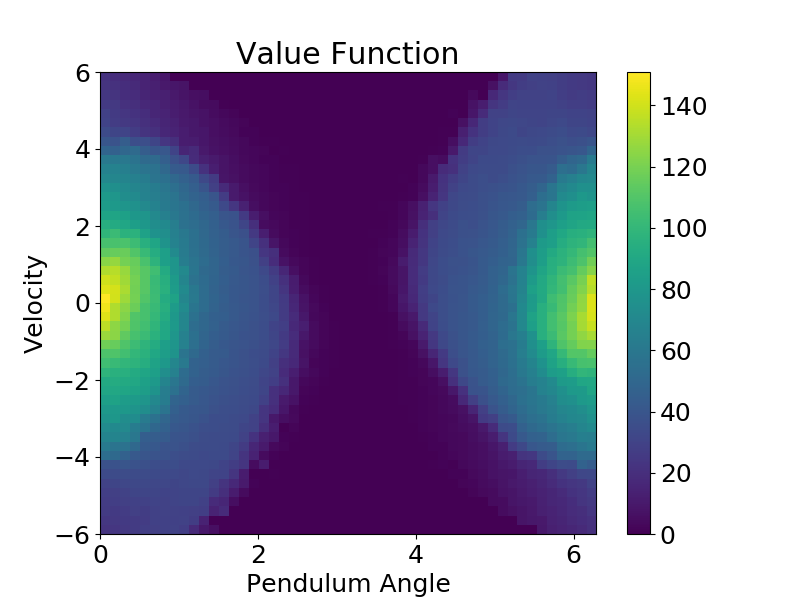

<IPython.core.display.Javascript object>


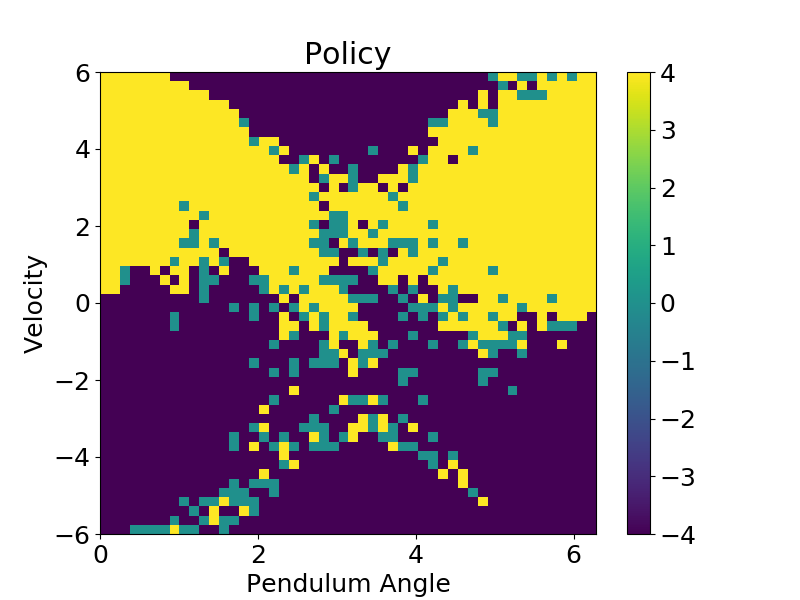

In [29]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function(q_table3)

# we plot the value function
plt.figure(figsize=[8,6])
plt.imshow(value_function.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')
plt.colorbar()

# we plot the policy
plt.figure(figsize=[8,6])
plt.imshow(policy.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')
plt.colorbar()

# increasing learning rate

In [30]:
def q_learning4(q_table):
    
    γ = 0.8
    ε = 0.1
    α = 0.99
    u = np.array([-4,0,4])
    
    c = []
    

    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    for i in range(10000):
        
        x = np.array([0, 0])
        cost = 0
        theta_index = np.argmin(np.abs(thetas - x[0]))
        omega_index = np.argmin(np.abs(omegas - x[1]))
        
        for j in range(100):
            
            
            if np.random.rand() < ε:
                
                u_index = np.random.randint(0,3)
                
            else:
                
                u_index = np.argmin(q_table[theta_index,omega_index])
                
            x_next = pendulum.get_next_state(x,u[u_index])
            
            new_theta_index = np.argmin(np.abs(thetas - x_next[0]))
            new_omega_index = np.argmin(np.abs(omegas - x_next[1]))
            
            
            δt= get_cost(x,u[u_index]) + α*np.min(q_table[new_theta_index,new_omega_index,:]) - q_table[theta_index,omega_index,u_index]
            
            q_table[theta_index,omega_index,u_index] = q_table[theta_index,omega_index,u_index] + γ*δt
            
            theta_index = new_theta_index
            omega_index = new_omega_index
            x = x_next        
            cost +=get_cost(x,u[u_index])
    
        c.append(cost)
        
                
    return q_table, c

In [31]:
q_table = np.zeros([50,50,3])
q_table4, c4 = q_learning4(q_table)

<IPython.core.display.Javascript object>


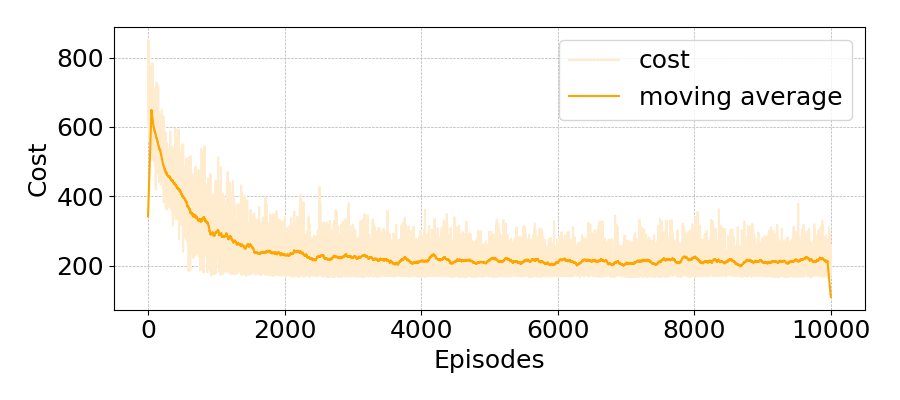

In [32]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,4])
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

c4_av = movingaverage(c4, 100)

plt.plot(c4,color = 'blanchedalmond', label = 'cost')
plt.plot(c4_av,color = 'orange', label = 'moving average')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [33]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller4(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    u = np.array([-4,0,4])
    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    theta_index = np.argmin(np.abs(thetas - x[0]))
    omega_index = np.argmin(np.abs(omegas - x[1]))
    
    u_index = np.argmin(q_table4[theta_index,omega_index,:])
    
    return u[u_index]


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x4, u4 = pendulum.simulate(x0, dummy_controller4, T)

<IPython.core.display.Javascript object>


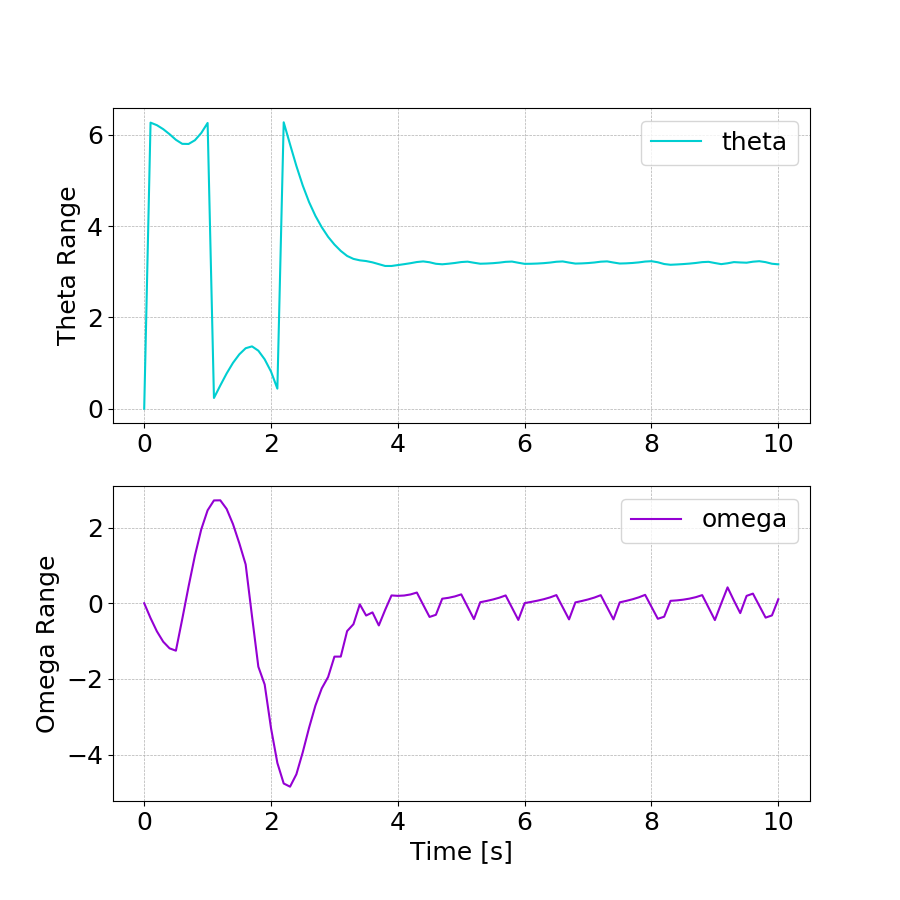

Text(0, 0.5, 'Omega Range')

In [34]:
# we can plot the results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,9])

plt.subplot(2,1,1)
plt.plot(t, x4[0,:], color = 'darkturquoise')
plt.legend(['theta'])
plt.grid(True, linestyle='--', linewidth = 0.5)
# plt.xlabel('Time (sec)')
plt.ylabel('Theta Range')

plt.subplot(2,1,2)
plt.plot(t, x4[1,:], color = 'darkviolet')
plt.legend(['omega'])
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Omega Range')

<IPython.core.display.Javascript object>


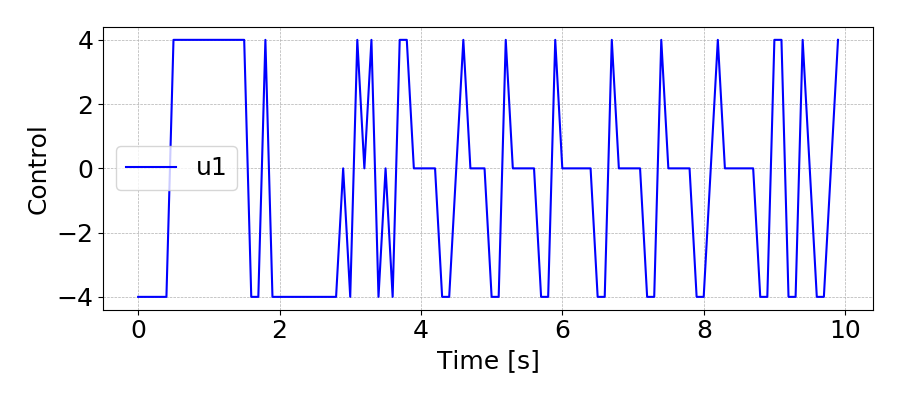

In [50]:
# we can also plot the control
plt.figure(figsize = [9,4])
plt.plot(t[:-1], u4.T, color = 'blue')
plt.legend(['u1'])
plt.xlabel('Time [s]')
plt.ylabel('Control')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [36]:
# now we can also create an animation
pendulum.animate_robot(x4)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACC/21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAATD2WI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320jncAqssSvtJt7NUh1hKLl50PVuKrrqytTymrOJOH8CDVWar0purKodI0zJeOimcq
bsTy++vIhJq7TluOY3ReWuPFYC+NymwAYUv5AHvr8KP6b6aIsUDpJiwpfeW3PfHhUvErEms1lqhs
q9469EpDggO6SXEgpE0FfthO1yVHR15Mu2CoIj+kG/XXaMWpu2Dr7OsGV6Z/qjWmIKOveP49dYdp
/C1NTyV7LLQy11L5NNSfsLWc4sQ3mTANyao6X+NykAy7mjb2tCZVkWZylgxdCoBs9vyRDhqF97tn
nhaSOn5DSXkvCUcUdul+EnqchmsEiIn+Z8Zfl5vjWnjuoAD1J4qVBKzkdBu3VhfEUZL6iWE5SxH1
eCnWfKMPTrbGAzainxDUyrD54ulVzC5T8pH6JA+9Vx0klmfDatYGKy68wW8Tjg66jtzlsm0fGU4t
ZJ8Bzyw3NFZafFWMcAmB4P6LU+TI5tishJSEgIjuWh85+/sKC+3bL++cOdlINq1B5pDAN1hVMsGU
nk++HfcKdAKUx7c3BkmCmx9sKFdsOfssEGH2lil1KEWlDOYiF+vM+ndjvOQhym53vElT1ySgAYS0
U1zQ0vxV7j73Ga12fNd/Dbts1ypP6Zms3aY9TVYJiVuTzGNfWAThP0nCkiPPosojmNM23pIgYMxu
VFR461JA6DywEWKbb+q+MjhARn/vgmppA7Y/wAkTQ7bAJG937lMJ/5UsJTVhbKO+Dk8H2V17mYb/
vXvHnX3BzXRHnVLcKqaPUHqmlToganuAM8P1MS0CW7hisSTq/ryxungWWjn3wzU3bVxP+rn5v53+
GCY2GXv6xxKp8QRWFlnZnAvtIvDFq2GscIuR9vZ45tYkFaxD+DqkjLYDcnnQdAUUhcVEMS14BT62
xu44KipEQ4Z53crqyP/5Te0/vidV/+Dup4ROzjDrcCACmX6T849bBm8YkoKn6MkgRvxN8mFlgk4D
GbrFueUZ06zym/u0GsqdsfMkMi5kPV2kTN2+mmnPvH4vXu1q1YyFjIKb+ACFKo+tSDZ/CYLP7cfV
tXQJdYBKMNWEJivLk/NG6AGYof/+3Bi00TccweVQhreR4kBH4AkJ7HRxugS69KCc15sy9efanNle
Zyd1xo+ewei+uQe986K9/ovb2kwMtraYCEBHX6/j0PXnS/3CZx55Kts83Q2D7lxTwX8YmLY49fGR
331HPFErIEUNwmN3Aj/e9ssZ+ZCJR97++yxBFC/xmRBAVFo+2hgFMAIir/7WiouOgAAACrsAWQpy
cIr1yNi3oJt4ION2/NF0GF6MpQDS9RwyyMhin4wIjiN4R+fkEvlqbF44ZugDmTuacVW/Ast2rMgB
7+YYvD9QZc1gvD+Oz2RDu6kaxzfgK9Kgd7sZBIjeKGdm2cCzw0Hwz33lotUP3zFtjoGM1p03yOJi
HTBWL1EQdfDqK3+L2wgj+YcnCkabHaMFa92oM+ffpB1yfn6qw3b0flBxPOD1DZ4Evk50EXvdG4gP
wouhIFPKOwzP9w0REFL4bNt6NGlHylNSow+E0LG0Tu5fgJTof7gXAMWY3nFR0RlTqIQjxm7z+l1m
nwmZBy3jKRVhbO7LxiM7DbD8RHVAF18LcYpTwgJfrnBo+v0Jc60lRI/hd0jmvR9awP8VWVJWjWIk
e7WRp7rI7QwFpUpIkn94CCi03viv0o7x1pmuLGSpmBDyaxEi+V6n/uin531T2nvo1PY+gyHcW+8E
7CGtvHjHEQlz23JpC883llrqnynzKSkHvL3TInfpjR/95rB1X6DVqZ0GtfvLxjreGMF+evsMuAiR
M686klzdW8UBIlLWITJtH0ReYeeqbB1ik+a7KhCOw1sClieQzZZB6OIqjQMEJyRgomMn3eMq+Mpp
vx5EXxtxh+r7iuZiECqFaQs7qJL2zUZtqbds0gaJeJHt3dNOq6+n27lKpflHfGSJP4jzSqYqpQkJ
OuEid13aY+nOERJ620DaR57U2KqnO4+hFcu9wWjHJ8JOXs2SoWeY62Xl+UhLAQi98xmv8Pod5H7G
HPbxxCnpiZTYW4Cf31rzCe7o+kGDVirPkhQDc9OjG+om8WbJn2MLfyhOdsK53pU3nyx8FAs/nF1k
0Q4gAAADAAADABU7M1+eAEBqptoePB0RkGggqexEZAB4t8cqrm/VCmpK2+Oaqbn1I2H52ZluDP5g
MCnfuybO6w4jPl7mJR8R90BAGz0beuR/THogQUBBWof7SoxRYSPkzAXXsTYnMVXsDr5EDoAimf99
4toPZKeIL0956dU4b84qHV8SWf8sPsBP8LPlKItenf1PCuCwBEvhQQyPdx3spYBk4jOoIbrNAlFU
WkW6R5qeV/0eLJJM9oMXjil9EdvP7+go7UwTK9DoTyAnCP/JG94cVngRodmhwSTdX1n4YZNmZY2o
edrk8sKiiFUrbIz1Q5t0FixLnmoswIc2ZXWSNN1OZyZx5U5FxGoiDfRylxjSQ5qdvNH5VfhZf1dc
iZdNigzbAnphPiz+K08TzWAKSkS7fMqxNN3JSd5cQKwIijdVxpBhWQZHYRFzlHvB3JtQWq4+JiMk
wArmaOyaV6NiZH7HU1tdi

<IPython.core.display.Javascript object>


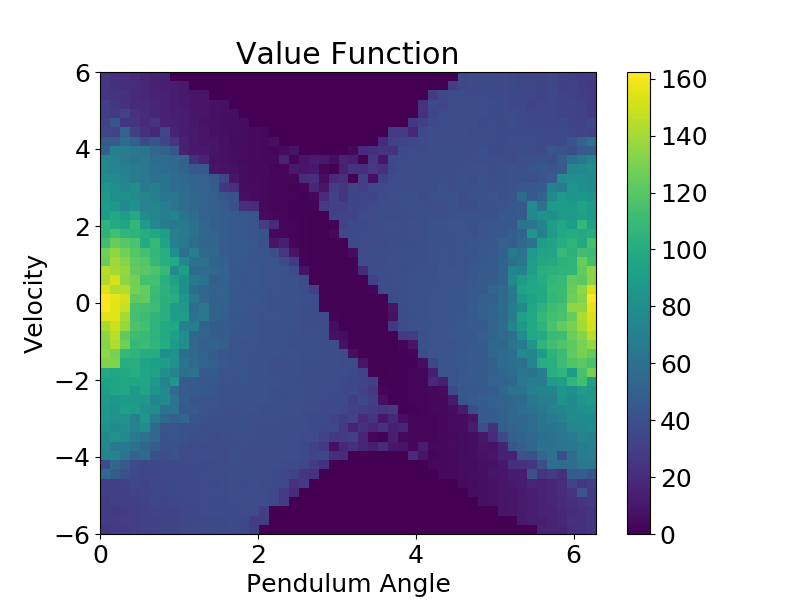

<IPython.core.display.Javascript object>


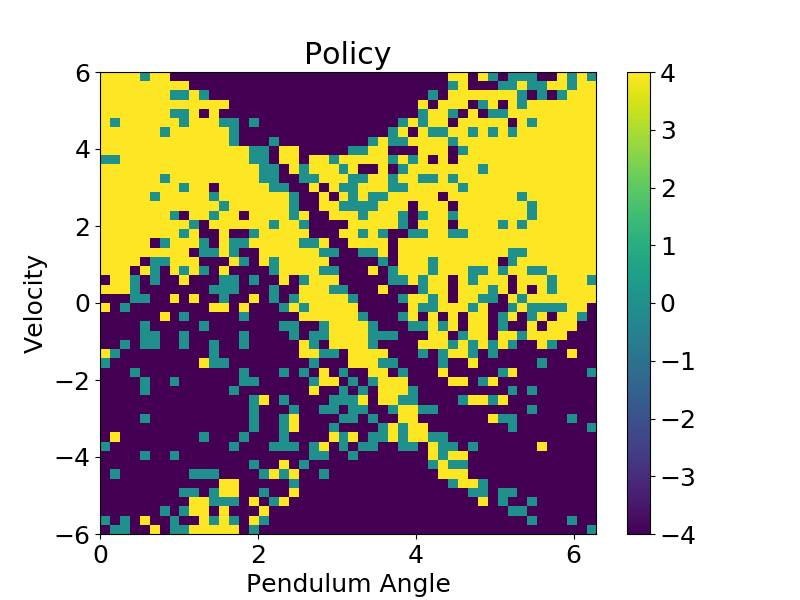

In [37]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function(q_table4)

# we plot the value function
plt.figure(figsize=[8,6])
plt.imshow(value_function.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')
plt.colorbar()

# we plot the policy
plt.figure(figsize=[8,6])
plt.imshow(policy.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')
plt.colorbar()

# increasing epsilon and learning rate

In [38]:
def q_learning5(q_table):
    
    γ = 0.8
    ε = 0.8
    α = 0.99
    u = np.array([-4,0,4])
    
    c = []
    

    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    for i in range(10000):
        
        x = np.array([0, 0])
        cost = 0
        theta_index = np.argmin(np.abs(thetas - x[0]))
        omega_index = np.argmin(np.abs(omegas - x[1]))
        
        for j in range(100):
            
            
            if np.random.rand() < ε:
                
                u_index = np.random.randint(0,3)
                
            else:
                
                u_index = np.argmin(q_table[theta_index,omega_index])
                
            x_next = pendulum.get_next_state(x,u[u_index])
            
            new_theta_index = np.argmin(np.abs(thetas - x_next[0]))
            new_omega_index = np.argmin(np.abs(omegas - x_next[1]))
            
            
            δt= get_cost(x,u[u_index]) + α*np.min(q_table[new_theta_index,new_omega_index,:]) - q_table[theta_index,omega_index,u_index]
            
            q_table[theta_index,omega_index,u_index] = q_table[theta_index,omega_index,u_index] + γ*δt
            
            theta_index = new_theta_index
            omega_index = new_omega_index
            x = x_next        
            cost +=get_cost(x,u[u_index])
    
        c.append(cost)
        
                
    return q_table, c

In [39]:
q_table = np.zeros([50,50,3])
q_table5, c5 = q_learning5(q_table)

/tmp/ipykernel_46406/2103263250.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = [9,4])


<IPython.core.display.Javascript object>


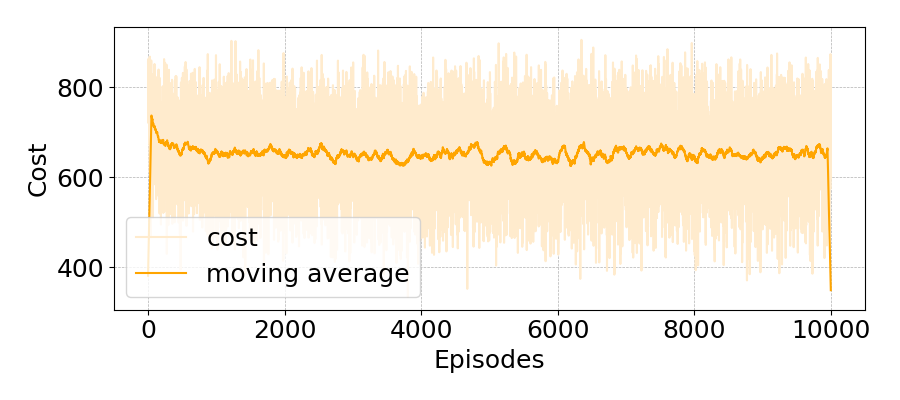

In [40]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,4])
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

c5_av = movingaverage(c5, 100)

plt.plot(c5,color = 'blanchedalmond', label = 'cost')
plt.plot(c5_av,color = 'orange', label = 'moving average')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [41]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller5(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    u = np.array([-4,0,4])
    
    thetas = np.linspace(0, 2*np.pi, 50, endpoint=False)
    omegas = np.linspace(-6, 6, 50)
    
    theta_index = np.argmin(np.abs(thetas - x[0]))
    omega_index = np.argmin(np.abs(omegas - x[1]))
    
    u_index = np.argmin(q_table5[theta_index,omega_index,:])
    
    return u[u_index]


# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0.,0.])
t, x5, u5 = pendulum.simulate(x0, dummy_controller5, T)

/tmp/ipykernel_46406/2998722343.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = [9,9])


<IPython.core.display.Javascript object>


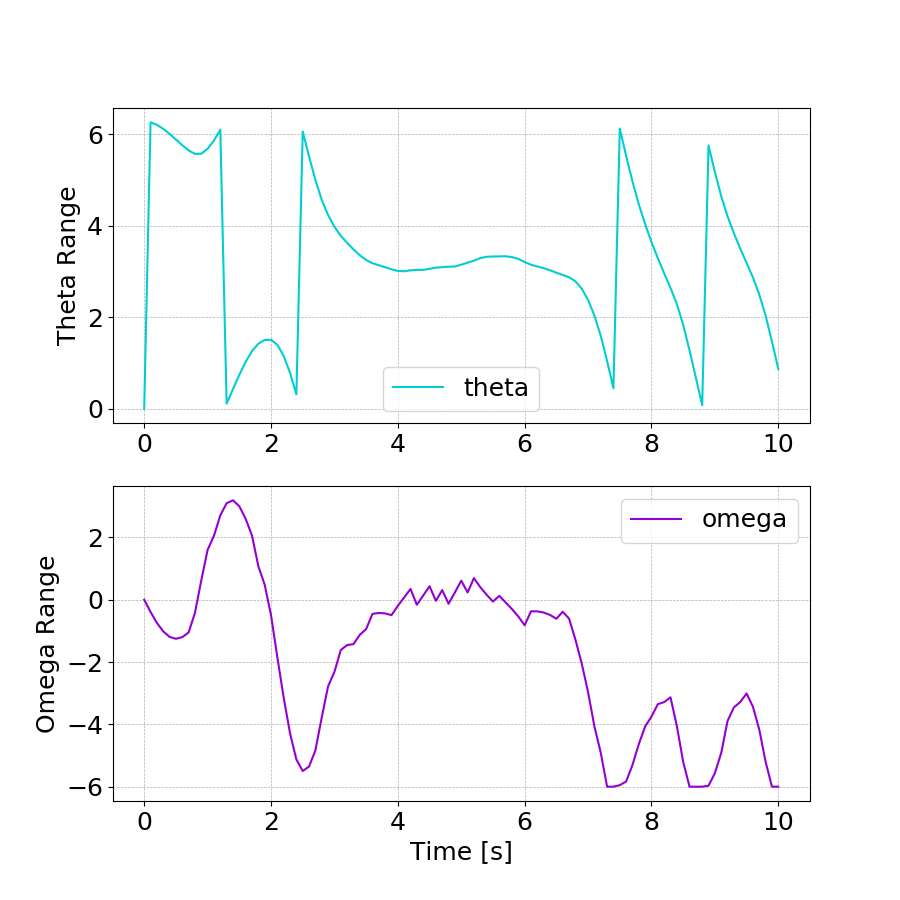

Text(0, 0.5, 'Omega Range')

In [42]:
# we can plot the results
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = [9,9])

plt.subplot(2,1,1)
plt.plot(t, x5[0,:], color = 'darkturquoise')
plt.legend(['theta'])
plt.grid(True, linestyle='--', linewidth = 0.5)
# plt.xlabel('Time (sec)')
plt.ylabel('Theta Range')

plt.subplot(2,1,2)
plt.plot(t, x5[1,:], color = 'darkviolet')
plt.legend(['omega'])
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Omega Range')

<IPython.core.display.Javascript object>


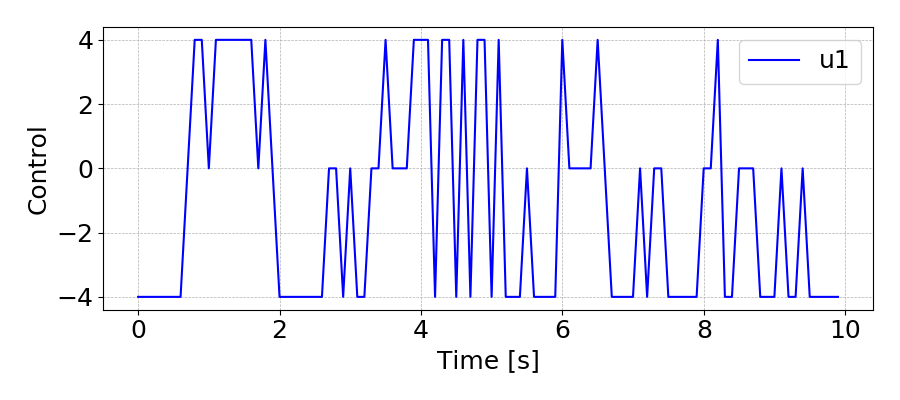

In [51]:
# we can also plot the control
plt.figure(figsize = [9,4])
plt.plot(t[:-1], u5.T, color = 'blue')
plt.legend(['u1'])
plt.xlabel('Time [s]')
plt.ylabel('Control')
plt.grid(True, linestyle='--', linewidth = 0.5)
plt.tight_layout()

In [44]:
# now we can also create an animation
pendulum.animate_robot(x5)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADHcG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAATGGWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320jncAqssSvtJt7NUh1hKLl50PVuKrrqytTymrOJOH8CDVWar0purKodI0zJeOimcq
bsTy++vIhJq7TluOY3ReWuPFYC+NymwAYUv5AHvr8KP6b6aIsUDpJiwpfeW3PfHhUvErEms1lqhs
q9469EpDggO6SXEgpE0FfthO1yVHR15Mu2CoIj+kG/XXaMWpu2Dr7OsGV6Z/qjWmIKOveP49dYdp
/C1NTyV7LLQy11L5NNSfsLWc4sQ3mTANyao6X+NykAy7mjb2tCZVkWZylgxdCoBs9vyRDhqF97tn
nhaSOn5DSXkvCUcUdul+EnqchmsEiIn+Z8Zfl5vjWnjuoAD1J4qVBKzkdBu3VhfEUZL6iWE5SxH1
eCnWfKMPTrbGAzainxDUyrD54ulVzC5T8pH6JA+9Vx0klmfDatYGKy68wW8Tjg66jtzlsm0fGU4t
ZJ8Bzyw3NFZafFWMcAmB4P6LU+TI5tishJSEgIjuWh85+/sKC+3bL++cOdlINq1B5pDAN1hVMsGU
nk++HfcKdAKUx7c3BkmCmx9sKFdsOfssEGH2lil1KEWlDOYiF+vM+ndjvOQhym53vElT1ySgAYS0
U1zQ0vxV7j73Ga12fNd/Dbts1ypP6Zms3aY9TVYJiVuTzGNfWAThP0nCkiPPosojmNM23pIgYMxu
VFR461JA6DywEWKbb+q+MjhARn/vgmppA7Y/wAkTQ7bAJG937lMJ/5UsJTVhbKO+Dk8H2V17mYb/
vXvHnX3BzXRHnVLcKqaPUHqmlToganuAM8P1MS0CW7hisSTq/ryxungWWjn3wzU3bVxP+rn5v53+
GCY2GXv6xxKp8QRWFlnZnAvtIvDFq2GscIuR9vZ45tYkFaxD+DqkjLYDcnnQdAUUhcVEMS14BT62
xu44KipEQ4Z53crqyP/5Te0/vidV/+Dup4ROzjDrcCACmX6T849bBm8YkoKn6MkgRvxN8mFlgk4D
GbrFueUZ06zym/u0GsqdsfMkMi5kPV2kTN2+mmnPvH4vXu1q1YyFjIKb+ACFKo+tSDZ/CYLP7cfV
tXQJdYBKMNWEJivLk/NG6AGYof/+3Bi00TccweVQhreR4kBH4AkJ7HRxugS69KCc15sy9efanNle
Zyd1xo+ewei+uQe986K9/ovb2kwMtraYCEBHX6/j0PXnS/3CZx55Kts83Q2D7lxTwX8YmLY49fGR
331HPNggn2FbomPQwQeKrMMXzotiaDid/JbMXiNAnmu6VhGeJ4OmDsAIir1k4dU7vWAAABKKAKCR
NBEV65Gl24WsMZT9vDoEUcZUKferiz3Ewf5VQ5XIkJrhSb6JyCXy1Ni8cM3QBzJ3NOKrfgWW7WmQ
A9/MMXh+oMuawXh/HZ7Ih3dSNY5vwFelQO92MgkRvFDOzbOBZ4aD4Z77y0WqH75i2x0DGa06b5HF
tew/fF6iIOvh1Fb/F7YQR/MOThSNNjtGCte7UGfPv0g65Pz9VYbt6Pyg4nnB6hs8CXyc6CL3ujcQ
H4UXQkCnlHYZn+4aIiCl8Nm29GjSj5SmpUYfDRFjaJ3cvwEp0P9wLgGLMbzio6Iyp1EIR4zd5/S6
zT4TMx5b6lIqwtnVl4xGdhth+IjqgC8WFuMUp4QEv1zg0fX6EudaSokfwu6STXo+tYH+KrKkrRrE
SPdrI091kdoYC0qaMST+8BBRab3xX6Ud460zXFjJUzAh5NYiRfK9T/3RT876p7T30ansfQZD6Lfe
CdhDW3jxjiIS57bk0heebyy11T5T5lJSD3l7pkTv0xo/+81g6r9Bq1M6DWv3l4x1vDGC/PX2GXAR
ImdedSS5ureKAkSlrEJk2j6IvMPPVNg6xSfNdlQhHYa2BSxPIZssg9HEVRoGCE5IwUTGT7vGVfGU
0348iL424w/V9xXMxCBVCtIWd1El7ZqM21Nu2aQNEvEj27umnVdfT7dylUvyjvjJEn8R5pVMVUoS
EnXCRO67tMfTnCIk9baBtI89qbFdTtnLYRXLvcFoxyfCTl7NkqFnmOtl5fk6hBoSFRvzFEevX3aj
XfPdCH+/0xMwcLcwDtwBLxoqTUQr0GPl3Z5YS2j+Qer5RA2WBvmb3hCN32rqBadc505CcvycPByQ
AAJuAAAR9rchY+5ReOd8ejwdEZBoIaae7cvYx84KOVVzfqbgRMN9xPzlPqRsPzszLR9f2l3LPGgq
Wuf/9Ka5sewg7XSIAP2AkdD3IvWmYG27ORWCB9VoP5JQEWVX7r1roWZYL2B18iBz0HFGQBMuBKjg
O+FBpd8jWyve0zkkS4MQ65JNrSzkxilEWvTv6VkYkOAiXugcYre472AvW54Rp5W3xYgG07hxjEMe
anlE6DaMwTPaDF44m2jJ6wLxYKO1L/iqMaEZbSnlQs28z9CAKfTU0w4JJur6z7Ps/w1Ph4/olVXf
CoohVK151YtObdBYsS5bqLMCHNmXzen4NTmcmceVOQkuqIhOMcpcY0kOanbzSkVX4WX9XXImSUYo
M2wJ6YT4s/fNPE81gCkn0W3zKsTTdyUnS3ECsCIo3VcaPuVkGR2ERc3x7wdybUFquPiYjJMAK5mj
smledYmR+x1NbXYmcvwbM

/tmp/ipykernel_46406/1970582149.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[8,6])


<IPython.core.display.Javascript object>


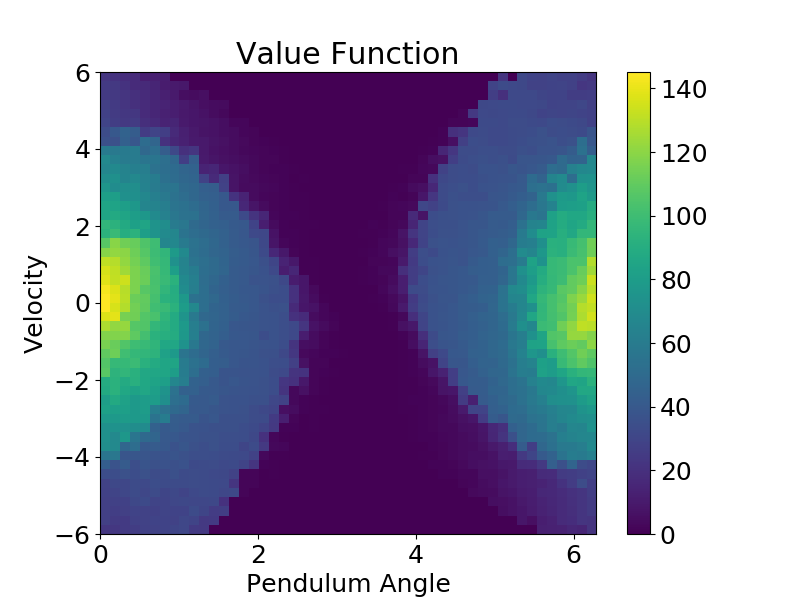

/tmp/ipykernel_46406/1970582149.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[8,6])


<IPython.core.display.Javascript object>


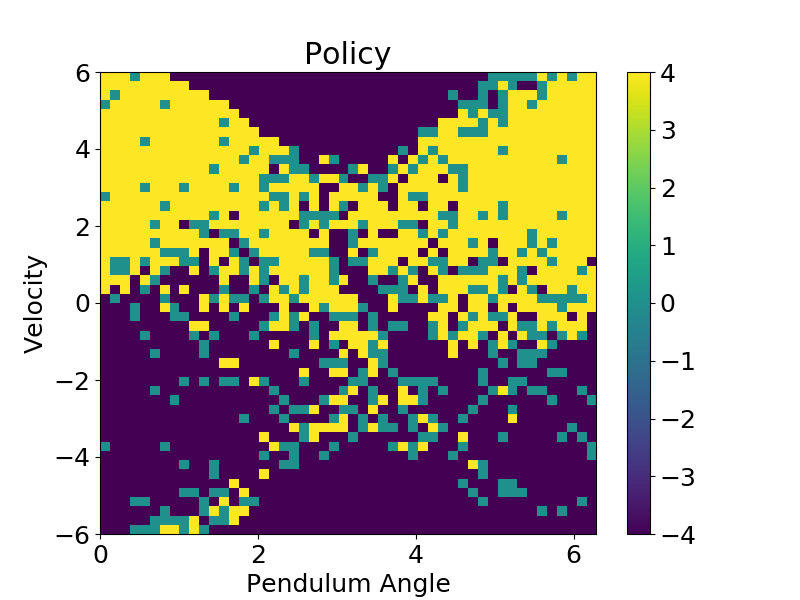

In [45]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function, policy = get_policy_and_value_function(q_table5)

# we plot the value function
plt.figure(figsize=[8,6])
plt.imshow(value_function.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')
plt.colorbar()

# we plot the policy
plt.figure(figsize=[8,6])
plt.imshow(policy.T[::-1], extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')
plt.colorbar()